# Выбор локации для скважины

Допустим, мы работаетм в добывающей компании «ГлавРосГосНефть». Необходимо выяснить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Так же проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель исследования:** 
1. Создание модели и комплекса инструментов для предсказани оптимального выбора региона и конкретых месторождений нефти с помощью машинного обучения.

**Задачи исследования:**
1. Подготовить и выделить данные на 2 выборки: обучающую и валидационную;
2. Обучить и проверить модели для каждого региона; 
3. Расчитать ожидаемую прибыль и выбрать безрисковые месторождения в регионах и регион для дальнейшей разработки.

**Объектом исследования** является информация о замерах показателей месторождений в трех регионах.

**Предметом исследования** является комплекс методик машинного обучения и инструментов связанных с МО.

**Ход выполнения**
1. Импортировать все необходимые библиотеки
2. Загрузить данные из трех файлов
3. Проанализировать общую информацию о качестве и структуре данных, предобработать данные
4. Разбить каждый из 3х датасетов на обучающую и валидационную выборки
5. Обучить и проверить модели (подойдет только линейная регрессия)
6. Рассчитать ожидаемую прибыль по месторождениям
7. Рассчитать вероятность рисков и прибыль в целом по регионам
8. Сделать выводы и рекомендации для дальнейшего исследования

**Описание данных**
Есть 3 набора данных, по каждому региону. Каждая строчка это характеристика месторождения 

Известно:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

Целевой признак
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Импорт библиотек и функций

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
state = np.random.RandomState(12345)

In [3]:
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    print ('MSE =', mse)
    return print('RMSE =',mse**0.5)

In [4]:
def full_info(data, name):
    print('Поверхностный анализ', name, '\n')
    display(pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm'))
    data.info()
    display(data.head(3))
    display(data.describe())
    data.hist(figsize=(20,20));

## Загрузка и подготовка данных

### Загрузка и обзор

In [5]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

В момент когда делал проект - ошибки с библиотекой ydata-profiling не было. На момент оформления проекта об ошибке разработчикам известно.

Поверхностный анализ Регион 0 



,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


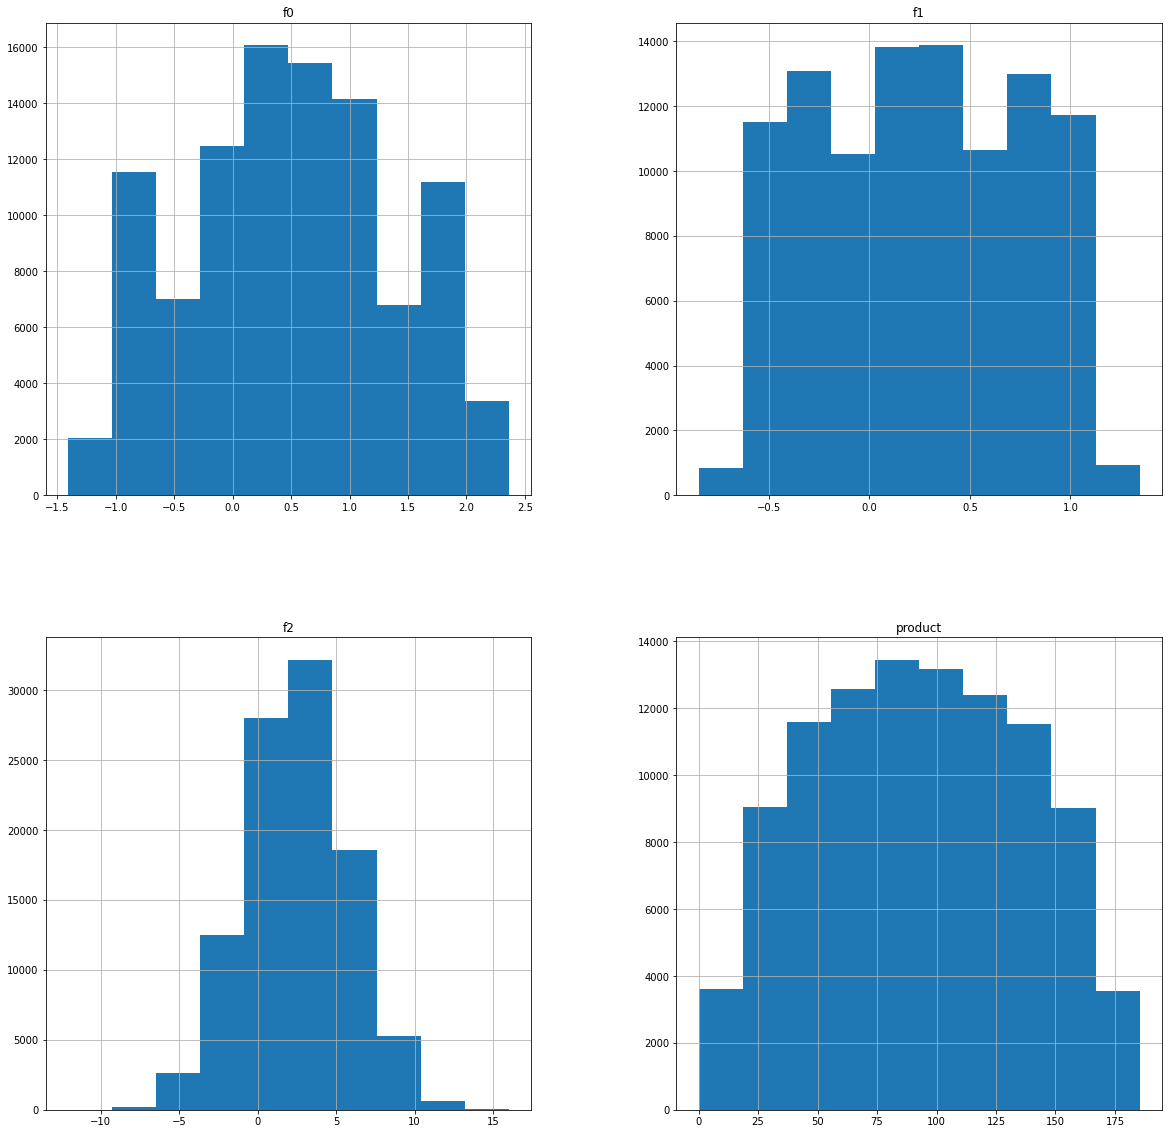

In [6]:
full_info(data0, 'Регион 0')

Поверхностный анализ Регион 1 



,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


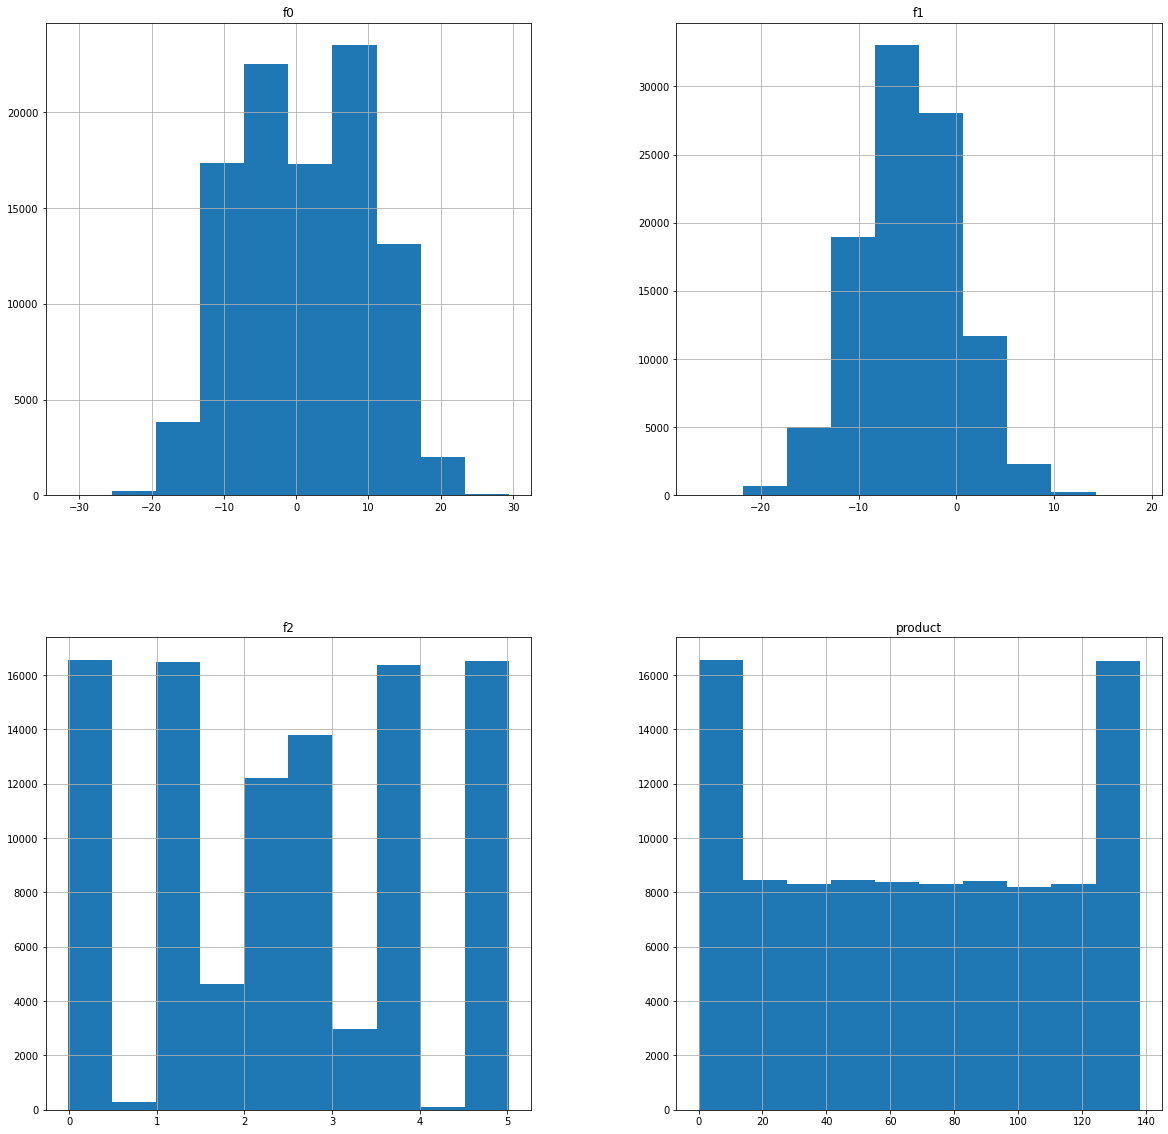

In [7]:
full_info(data1, 'Регион 1')

Поверхностный анализ Регион 2 



,0
id,0.000000
f0,0.000000
f1,0.000000
f2,0.000000
product,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


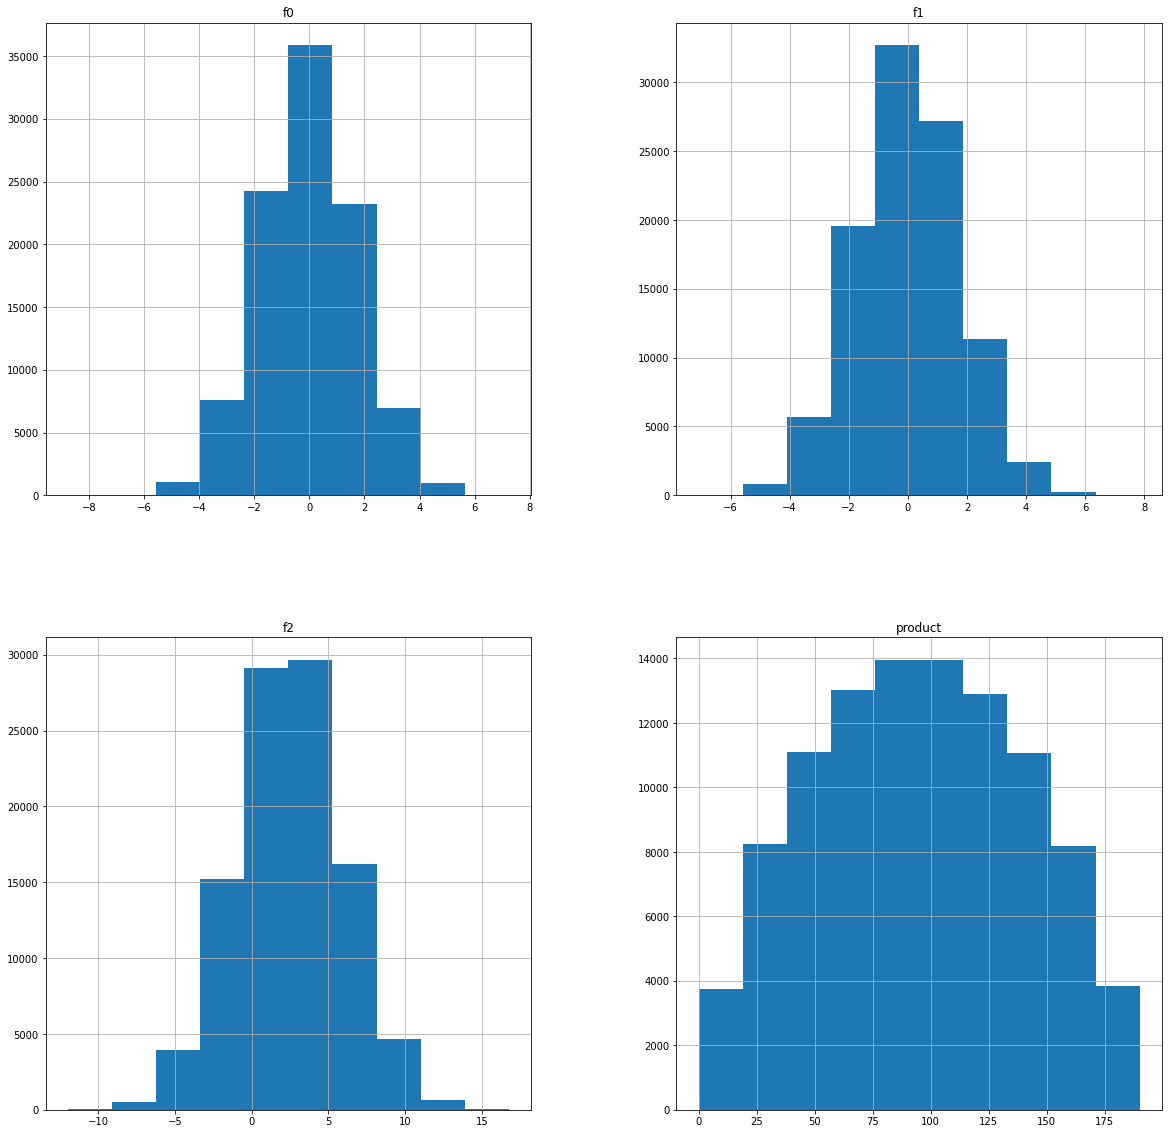

In [8]:
full_info(data2, 'Регион 2')

Данные в порядке

### Разделение на выборки

In [9]:
features0 = data0.loc[:,'f0':'f2']
target0 = data0['product']
features1 = data1.loc[:,'f0':'f2']
target1 = data1['product']
features2 = data2.loc[:,'f0':'f2']
target2 = data2['product']

Стандартизируем данные

In [10]:
for _f in [features0, features1, features2]:
    print(_f.head(3))

         f0        f1        f2
0  0.705745 -0.497823  1.221170
1  1.334711 -0.340164  4.365080
2  1.022732  0.151990  1.419926
          f0        f1        f2
0 -15.001348 -8.276000 -0.005876
1  14.272088 -3.475083  0.999183
2   6.263187 -5.948386  5.001160
         f0        f1        f2
0 -1.146987  0.963328 -0.828965
1  0.262778  0.269839 -2.530187
2  0.194587  0.289035 -5.586433


In [11]:
for df in [features0, features1, features2]:
    scaler = StandardScaler()
    scaler.fit(df.loc[:,'f0':'f2'])
    df.loc[:,'f0':'f2'] = scaler.transform(df.loc[:,'f0':'f2'])

In [12]:
for _f in [features0, features1, features2]:
    print(_f.head(3))

         f0        f1        f2
0  0.235512 -1.482793 -0.394515
1  0.956946 -1.170246  0.573368
2  0.599101 -0.194581 -0.333326
         f0        f1        f2
0 -1.800451 -0.679595 -1.467757
1  1.464528  0.258112 -0.877783
2  0.571264 -0.224969  1.471398
         f0        f1        f2
0 -0.663387  0.557908 -0.957007
1  0.150548  0.157142 -1.446788
2  0.111178  0.168235 -2.326682


Изменение удачно

In [13]:
features0_train, features0_valid, target0_train, target0_valid = train_test_split(
    features0, target0, test_size=0.25, random_state=12345)
features1_train, features1_valid, target1_train, target1_valid = train_test_split(
    features1, target1, test_size=0.25, random_state=12345)
features2_train, features2_valid, target2_train, target2_valid = train_test_split(
    features2, target2, test_size=0.25, random_state=12345)

In [14]:
for df in ['features0_train','target0_train','features0_valid', 'target0_valid', 
          'features1_train','target1_train','features1_valid', 'target1_valid',
          'features2_train','target2_train','features2_valid', 'target2_valid',]:
    print(f'Размерность {df}: {globals()[df].shape}')

Размерность features0_train: (75000, 3)
Размерность target0_train: (75000,)
Размерность features0_valid: (25000, 3)
Размерность target0_valid: (25000,)
Размерность features1_train: (75000, 3)
Размерность target1_train: (75000,)
Размерность features1_valid: (25000, 3)
Размерность target1_valid: (25000,)
Размерность features2_train: (75000, 3)
Размерность target2_train: (75000,)
Размерность features2_valid: (25000, 3)
Размерность target2_valid: (25000,)


## Обучение и проверка модели

In [15]:
targets = []
for features_train, target_train, features_valid, target_valid, region in zip(
    [features0_train,features1_train,features2_train],
    [target0_train,target1_train,target2_train],
    [features0_valid,features1_valid,features2_valid],
    [target0_valid,target1_valid,target2_valid],
    ['Регион 0', "Регион 1", "Регион 2"]):
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    target_predict = model.predict(features_valid)
    targets.append(target_predict)
    print(region)
    print('Константная модель')
    target_mean = pd.Series([target_train.mean()] * len(target_valid))
    rmse(target_valid, target_mean)
    print('\n Проверка модели')
    rmse(target_valid, target_predict)
    print('Средний объем предсказанного сыръя:', target_predict.mean())
    print("___________\n")

Регион 0
Константная модель
MSE = 1961.5678757223516
RMSE = 44.289591053907365

 Проверка модели
MSE = 1412.2129364399243
RMSE = 37.5794217150813
Средний объем предсказанного сыръя: 92.59256778438035
___________

Регион 1
Константная модель
MSE = 2117.9734309299147
RMSE = 46.02144533725462

 Проверка модели
MSE = 0.7976263360391158
RMSE = 0.893099286775617
Средний объем предсказанного сыръя: 68.72854689544602
___________

Регион 2
Константная модель
MSE = 2016.2210072435087
RMSE = 44.90234968510566

 Проверка модели
MSE = 1602.3775813236196
RMSE = 40.02970873393434
Средний объем предсказанного сыръя: 94.96504596800489
___________



**Вывод:** Лучше всего предскажывает модель Региона 1, но там наименьшее среднее предсказанное значение продукта: 69 ед.,
По остальным регионам в среднем предсказывает 92-95 ед. продукта. Но RMSE (разброс предсказаний) = 37-40 ед. 
Модели проверены на адекватность(по сравнению со средним значением): результат незначительно, но лучше (кроме региона 1).

## Подготовка к расчёту прибыли

In [16]:
target0_predict= targets[0]
target1_predict= targets[1]
target2_predict= targets[2]

print(target0_predict[:5])
print(target1_predict[:5])
print(target2_predict[:5])

[95.89495185 77.57258261 77.89263965 90.17513418 70.51008829]
[82.66331365 54.43178616 29.74875995 53.5521335   1.24385647]
[ 93.59963303  75.10515854  90.06680936 105.16237507 115.30331048]


In [17]:
prods0 = pd.DataFrame({'real' : target0_valid, 'pred':target0_predict}).sort_values(by = 'pred', ascending=False)
prods1 = pd.DataFrame({'real' : target1_valid, 'pred':target1_predict}).sort_values(by = 'pred', ascending=False)
prods2 = pd.DataFrame({'real' : target2_valid, 'pred':target2_predict}).sort_values(by = 'pred', ascending=False)

In [18]:

min_pr_for_region = 10_000_000_000/450_000
min_pr_for_well = min_pr_for_region/200
print('Суммарный необходимый объем нефти 200 скважин для безубыточной разработки региона:',min_pr_for_region)
print('Средний продукт 1 скважины для этого:',min_pr_for_well)

Суммарный необходимый объем нефти 200 скважин для безубыточной разработки региона: 22222.222222222223
Средний продукт 1 скважины для этого: 111.11111111111111


Сравнивая средний минимальный объем продукта в скважинах региона для безубыточности(111 ед.) и средний предсказанный объем месторождений(68-95 ед.), можно сказать, что это будет задача не из легких. Если выбирать случайным образом месторождения для разработки то высока вероятность убытков.  

## Расчёт прибыли и рисков 

### Расчет прибыли по 200 лучшим месторождениям

In [19]:
def region_profit(prod,count):
    prod = prod[:count]
    profit = sum(prod['real'])*450_000 - 10_000_000_000
    return profit

In [20]:
print("Прибыль при разработке 200 лучших скважин Региона 0 -", round(region_profit(prods0, 200)/1000000000,2), "млрд.")
print("Прибыль при разработке 200 лучших скважин Региона 1 -", round(region_profit(prods1, 200)/1000000000,2), "млрд.")
print("Прибыль при разработке 200 лучших скважин Региона 2 -", round(region_profit(prods2, 200)/1000000000,2), "млрд.")

Прибыль при разработке 200 лучших скважин Региона 0 - 3.32 млрд.
Прибыль при разработке 200 лучших скважин Региона 1 - 2.42 млрд.
Прибыль при разработке 200 лучших скважин Региона 2 - 2.71 млрд.


### Расчет прибыли и рисков с помощью bootstrap

In [21]:
#Функция теники бутстреп с отрисовкой графиков распределения прибыли
def bootstrap(prod, count, name):
    values=[]
    for i in range(1000):
        prod_subsample = (prod.sample(n=500, replace=False, random_state=state)
                          .sort_values(by = 'pred', ascending=False)[:count])
        values.append(region_profit(prod_subsample, count))
    values = pd.Series(values)
    values_mean = (values.mean()/1000000).round(2)
    q_05 = (values.quantile(0.025)/1000000).round(2)
    q_95 = (values.quantile(0.975)/1000000).round(2)
    print(name)
    print('Средний размер прибыли', values_mean, "млн.руб")
    print('95% доверительный интервал:', q_05, "-", q_95, "млн.руб")
    print('Риск убытков:', ((values < 0).mean()*100).round(2),"%")
    plt.figure(figsize=(12, 5))
    plt.hist(values/1000000, bins=50)
    plt.axvline(x=values_mean, color='red', label = 'Средняя прибыль')
    plt.axvline(x=q_05, linestyle='--', color='green', label = '95% доверительный интервал')
    plt.axvline(x=q_95, linestyle='--', color='green')
    plt.xlabel('Прибыль, млн.руб.')
    plt.ylabel('Количество')
    plt.title('График распределения прибыли')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    print('_________________\n')

Регион 0
Средний размер прибыли 386.45 млн.руб
95% доверительный интервал: -137.19 - 908.96 млн.руб
Риск убытков: 5.7 %


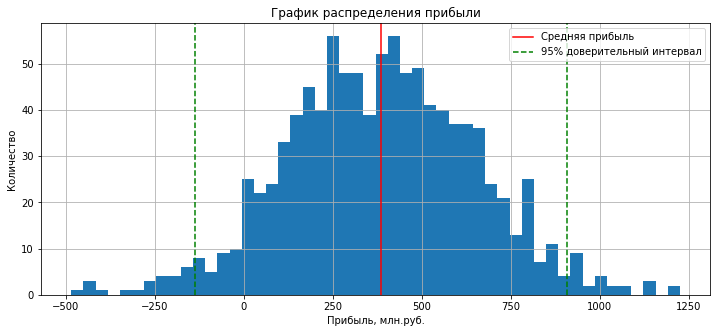

_________________

Регион 1
Средний размер прибыли 466.12 млн.руб
95% доверительный интервал: 63.19 - 856.63 млн.руб
Риск убытков: 0.9 %


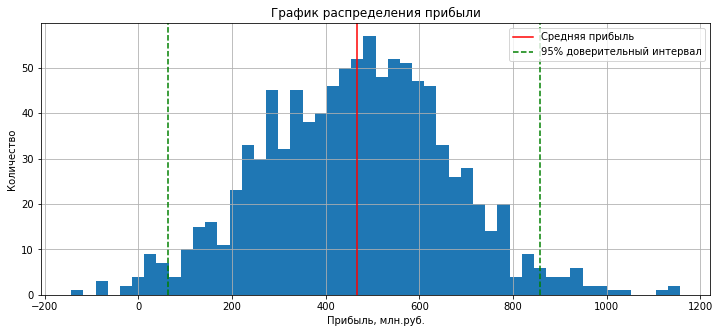

_________________

Регион 2
Средний размер прибыли 383.47 млн.руб
95% доверительный интервал: -116.14 - 890.36 млн.руб
Риск убытков: 8.3 %


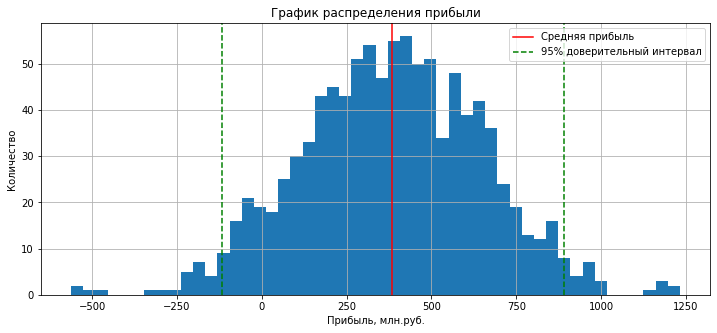

_________________



In [22]:
bootstrap(prods0, 200, 'Регион 0')
bootstrap(prods1, 200, 'Регион 1')
bootstrap(prods2, 200, 'Регион 2')

**Вывод:** Минимальный риск убытков у региона 1 (около 1%), у остальных он в 5-6 раз больше.
И самый высокий показатель средней прибыли так же в регионе 1. Таким образом выбираем для освоения именно Регион 1

Так же видим распределение прибыли при случайных комбинациях: в 0 и 2 регионах убыток может достигать до 200 млн.руб.
В регионе 1 такой ситуации нет, 95% доверительный интервал весь в прибыли.

## Итоговый вывод

 **1.** Была достигнута цель исследования - С помощъю машинного обучения и техники Бутстреп проанализированы месторождения трех регионов и определен оптимальный регион для разработки, для этого было сделано:
- Разделены данные о месторождениях нефти трех регионов на 2 выборки каждый: обучающую, валидационную в соотношении 3:1
- Количественные признаки промасштабированы
- Обучена модель линейной регрессии для предсказания объемов нефти по трем количественным факторам в месторождениях отдельно по каждому региону, результаты предсказаний сохранены.
- Высчитана точка безубыточности разработки 200 скважин(сколько нефти должно быть суммарно в них).
- Составлена функция подсчета показателей(средняя прибыль, 95% доверительный интервал, риск убытков) по 200 лучшим месторождениям(выбраны *по предсказанным* данным, посчитаны *по реальным*) из 500 месторождений выбранных случайно 1000 разными способами из 25000 месторождений. 
    
**2.** Для безубыточности проработки региона (исследовать 500 месторождений и построить вышку на 200а лучших), необходимо чтобы суммарно у них было не менее 22222.(2) тыс.баррелей, значит у каждого месторождения в среднем 111.(1) тыс. баррелей


**3.** В конечном итоге выбираем Регион 1, т.к. у ниго лучшие показатели (по Бутстрепу):
- Риск убытков около 1%(в остальных 5-7%)
- Средняя прибыль минимум на 50 млн.руб. больше.
- 95% доверительный интервал целиком находится в прибыли, чего не сказать про другие регионы